In [261]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [262]:
data = pd.read_csv('expanded', delimiter='\t', header=None, names=['characteristics'])
data = data['characteristics'].str.split(',', expand=True)
data = data.drop(range(7)).reset_index(drop=True)



In [263]:
# implement descriptive column names
column_names = ['edibility','cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat']
data.columns = column_names
data = data.drop(data[data.isnull().any(axis=1)].index)

In [264]:
# get dummy variables for two-level response
def var_transform (data):
    data['edibility']=data['edibility'].apply(lambda x: 1 if x=='EDIBLE' else 0)
    #data['odor']=data['odor'].apply(lambda x: 0 if x=='ALMOND' or x=='ANISE' else 1)
    # put further variable transformation here 
    return data
var_transform(data).head(2)

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS


In [265]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df=data
# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat'], drop_first=True)
# Calculate VIF for each predictor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["Predictor"] = df.columns

# Print the VIF values
vif

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,Predictor
0,inf,edibility
1,1.340183,cap_shape_CONICAL
2,8.278594,cap_shape_CONVEX
3,8.645659,cap_shape_FLAT
4,3.856771,cap_shape_KNOBBED
...,...,...
91,1.930608,habitat_MEADOWS
92,3.292256,habitat_PATHS
93,2.587564,habitat_URBAN
94,inf,habitat_WASTE


In [266]:
df.shape

(8416, 96)

In [267]:
vif_inf = vif[np.isinf(vif['VIF Factor'])]
vif_inf

,VIF Factor,Predictor
0,inf,edibility
18,inf,bruises_NO
20,inf,odor_CREOSOTE
21,inf,odor_FISHY
22,inf,odor_FOUL
23,inf,odor_MUSTY
24,inf,odor_NONE
25,inf,odor_PUNGENT
26,inf,odor_SPICY
29,inf,gill_size_NARROW


# Feature Engineering

In [268]:
data_encoded = data.drop(['odor','veil_type'], axis=1)
#,'stalk_color_below_ring','stalk_surface_above_ring'

In [271]:
#use label encoding instead 
from sklearn.preprocessing import LabelEncoder 
label = LabelEncoder()
for col in data_encoded.columns:
    if data_encoded[col].dtypes =='O':
        data_encoded[col]=label.fit_transform(data_encoded[col])
data_encoded.head()

,edibility,cap_shape,cap_surface,cap_color,bruises,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,...,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,2,3,8,0,1,1,1,10,1,...,3,3,7,7,2,1,4,6,4,6
1,1,2,3,8,0,1,1,1,10,1,...,3,3,7,7,2,1,4,1,4,6
2,1,2,3,8,0,1,1,1,7,1,...,3,3,7,7,2,1,4,6,4,6
3,1,2,3,8,0,1,1,1,7,1,...,3,3,7,7,2,1,4,1,4,6
4,1,2,3,8,0,1,1,1,1,1,...,3,3,7,7,2,1,4,6,4,6


In [272]:
# create dummy variables for each categorical variable
#cat_vars = list(data.select_dtypes(include=['object']).columns)
#dummy_vars = pd.get_dummies(data[cat_vars], prefix=cat_vars)
# concatenate the dummy variables with the original dataset
#data = pd.concat([data.drop(cat_vars, axis=1), dummy_vars], axis=1)

print(data.shape)

(8416, 23)


In [273]:
X = data_encoded.drop('edibility',axis=1)
y = data_encoded['edibility']

In [317]:
from sklearn.feature_selection import SelectKBest, chi2
features_kbest = SelectKBest(chi2, k=15).fit(X,y)

In [318]:
feature_names = features_kbest.get_feature_names_out()
feature_names

array(['cap_shape', 'cap_surface', 'cap_color', 'bruises', 'gill_spacing',
       'gill_size', 'gill_color', 'stalk_shape', 'stalk_root',
       'stalk_surface_above_ring', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'ring_type', 'spore_print_color',
       'population'], dtype=object)

In [319]:
X_filtered = data_encoded[feature_names]
X_filtered.head()

,cap_shape,cap_surface,cap_color,bruises,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_color_above_ring,stalk_color_below_ring,ring_type,spore_print_color,population
0,2,3,8,0,1,1,10,1,1,3,7,7,4,6,4
1,2,3,8,0,1,1,10,1,1,3,7,7,4,1,4
2,2,3,8,0,1,1,7,1,1,3,7,7,4,6,4
3,2,3,8,0,1,1,7,1,1,3,7,7,4,1,4
4,2,3,8,0,1,1,1,1,1,3,7,7,4,6,4


# Feature Selection for model without Odor

In [311]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

In [320]:
from sklearn.model_selection import train_test_split
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered,
    y,
    test_size=0.15,
    random_state=23)

X_train.shape, X_test.shape

((7153, 15), (1263, 15))

In [321]:
#experiment with label encoding 

In [322]:
cutoff=0.4
def fit_logit_reg(X,Y):
    # Fit linear regression model and return classification accuracy
    model_k = LogisticRegression()
    model_k.fit(X, Y)

    # Predicted vs Actual
    actual_values = Y
    pred_values = model_k.predict(X)
    bins = np.array([0, cutoff, 1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]

    # Calculate the accuracy
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    fpr = (cm[0,1]) / (cm[0,0] + cm[0,1])

    #print("Classification accuracy = {:.1%}".format(accuracy))
    #print("FPR = {:.1%}".format(fpr))

    return accuracy, fpr

In [323]:
#forward selection
k = 15

remaining_features = list(X_train.columns.values)
features = []
accuracy_list, fpr_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_accuracy = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            accuracy = fit_logit_reg(X_train[list(combo) + features],y_train)   #Store temp result 

            if accuracy[0] < best_accuracy:
                best_accuracy = accuracy[0]
                best_fpr = accuracy[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    accuracy_list.append(best_accuracy)
    fpr_list.append(best_fpr)
    features_list[i] = features.copy()

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [324]:
df = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'accuracy':accuracy_list, 'fpr': fpr_list})], axis=1, join='inner')
df['numb_features'] = df.index
df.tail(10)

,features,accuracy,fpr,numb_features
6,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.663358,0.422123,6
7,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.684748,0.383857,7
8,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.740389,0.286996,8
9,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.771005,0.234679,9
10,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.792395,0.222123,10
11,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.817279,0.203288,11
12,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.820215,0.208371,12
13,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.846079,0.185052,13
14,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.887180,0.146188,14
15,"[cap_color, cap_surface, stalk_shape, stalk_su...",0.929680,0.082511,15


In [325]:
df.features.iloc[-1]

['cap_color',
 'cap_surface',
 'stalk_shape',
 'stalk_surface_above_ring',
 'stalk_color_above_ring',
 'stalk_color_below_ring',
 'cap_shape',
 'gill_color',
 'ring_type',
 'bruises',
 'stalk_root',
 'spore_print_color',
 'population',
 'gill_spacing',
 'gill_size']

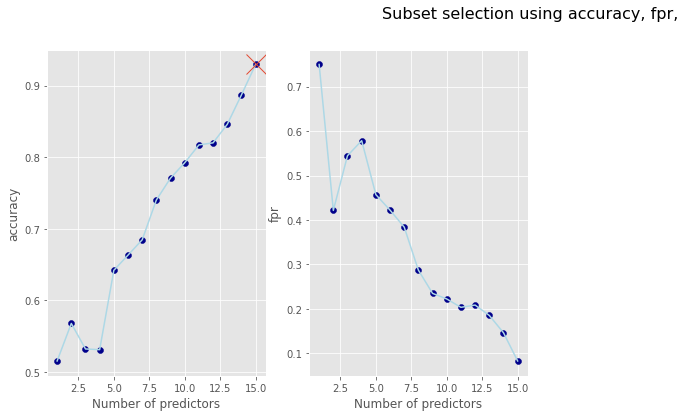

In [326]:
variables = ['accuracy','fpr']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df['numb_features'],df[v], color = 'lightblue')
    ax.scatter(df['numb_features'],df[v], color = 'darkblue')
    if v == 'accuracy':
        ax.plot(df[v].idxmax(),df[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df[v].idxmin(),df[v].min(), markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using accuracy, fpr, ', fontsize = 16)
plt.show()

In [327]:
##also forward selection, but using Machine learning

# SequentialFeatureSelector

In [329]:
!pip install mlxtend

In [332]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs_forward = SFS(LogisticRegression(), 
                  k_features=10, 
                  forward=True, 
                  floating=False, 
                  verbose=2,
                  scoring='accuracy',
                  cv=5)
sfs_forward = sfs_forward.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished

[2023-03-11 17:11:26] Features: 1/10 -- score: 0.7616404001309661[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.5s finished

[2023-03-11 17:11:27] Features: 2/10 -- score: 0.8671903358695812[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.7s finished

[2023-03-11 17:11:28] Features: 3/10 -- score: 0.8671903358695812[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [333]:
selected_features = X_train.columns[list(sfs_forward.k_feature_idx_)]
selected_features

Index(['cap_shape', 'cap_color', 'bruises', 'gill_spacing', 'gill_size',
       'gill_color', 'stalk_shape', 'stalk_surface_above_ring',
       'stalk_color_above_ring', 'stalk_color_below_ring'],
      dtype='object')

In [334]:
# Evaluate the model using the selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[selected_features], y_train)
y_pred = logreg.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)

In [335]:
# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)

Accuracy: 0.9406175771971497
False positive rate: 0.07032590051457976


In [336]:
#Calculate recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print('Recall:', recall)

Recall: 0.95


# Tuning the threshold in Logistic Regression in Scikit Learn

In [338]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score, f1_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
data=[]
THRESHOLDS=np.arange(0.01,1,0.01)
for THRESHOLD in THRESHOLDS:
  preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
  data.append([accuracy_score(y_test, preds), recall_score(y_test, preds),
                    precision_score(y_test, preds), roc_auc_score(y_test, preds), f1_score(y_test, preds)])
  
df=pd.DataFrame(data=np.array(data).T, columns=THRESHOLDS,
              index=["accuracy", "recall", "precision", "roc_auc_score", 'f1_score']).T
df

,accuracy,recall,precision,roc_auc_score,f1_score
0.01,0.664291,0.998529,0.616152,0.636486,0.762065
0.02,0.711006,0.986765,0.653359,0.688065,0.786175
0.03,0.737926,0.980882,0.677157,0.717714,0.801201
0.04,0.775139,0.977941,0.711991,0.758267,0.824040
0.05,0.787807,0.977941,0.724401,0.771989,0.832290
...,...,...,...,...,...
0.95,0.711006,0.464706,0.996845,0.731495,0.633902
0.96,0.679335,0.405882,0.996390,0.702084,0.576803
0.97,0.642914,0.336765,1.000000,0.668382,0.503850
0.98,0.604909,0.266176,1.000000,0.633088,0.420441


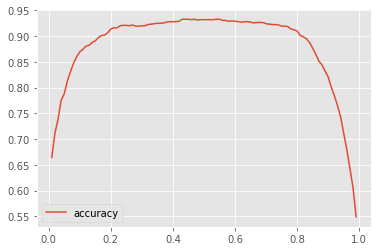

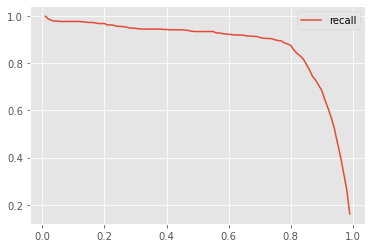

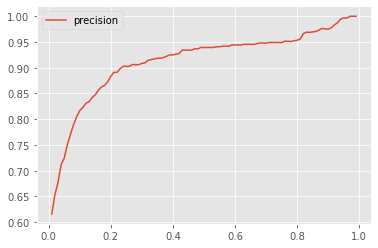

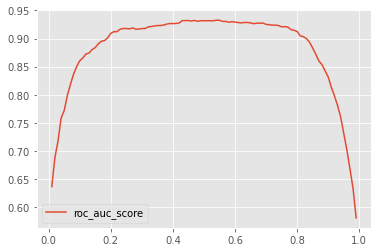

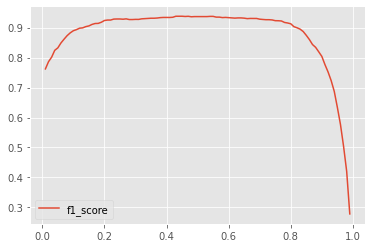

In [339]:
for col in df.columns:
  df[[col]].plot()
  plt.show()

# Backward Selection
crashing my laptop

In [59]:
#backward selection
sfs_backward = SFS(LogisticRegression(), 
                   k_features=20, 
                   forward=False, 
                   floating=False, 
                   verbose=2,
                   scoring='accuracy',
                   cv=5)
sfs_backward = sfs_backward.fit(np.array(X_train), y_train)

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yushansun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

In [32]:
# Get the selected feature subset
selected_features_bwd = X_train.columns[list(sfs_backward.k_feature_idx_)]
selected_features_bwd

Index(['cap_shape_BELL', 'cap_shape_CONICAL', 'cap_shape_CONVEX',
       'cap_shape_FLAT', 'cap_shape_KNOBBED', 'cap_shape_SUNKEN',
       'cap_surface_FIBROUS', 'cap_surface_GROOVES', 'cap_surface_SCALY',
       'bruises_BRUISES', 'odor_ALMOND', 'odor_ANISE', 'odor_CREOSOTE',
       'odor_FISHY', 'odor_FOUL', 'odor_SPICY', 'gill_size_BROAD',
       'stalk_root_CLUB', 'stalk_surface_above_ring_SILKY',
       'spore_print_color_GREEN'],
      dtype='object')

In [33]:
# Evaluate the model using the selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[selected_features_bwd], y_train)
y_pred = logreg.predict(X_test[selected_features_bwd])
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [34]:
# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)
print('Recall:', recall)

Accuracy: 1.0
False positive rate: 0.0
Recall: 1.0


In [79]:
# Evaluate the model using the consistently selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[consistent_features], y_train)
y_pred = logreg.predict(X_test[consistent_features])
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [80]:
# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)
print('Recall:', recall)

Accuracy: 0.8479809976247031
False positive rate: 0.27615780445969124
Recall: 0.9544117647058824
